In [1]:
from prompts.human_request_prompt import USER_PROMPT
from dotenv import load_dotenv, find_dotenv
from states.MainStateAsync import MainState, TpByAgent
from langgraph.graph import START, StateGraph, END
import os
import pandas as pd
# import time
from IPython.display import Image, display
from langgraph.constants import Send
# from pydantic import BaseModel

from agents.RAG_agent  import agent_rag_chained

In [2]:
_ = load_dotenv(find_dotenv())

api_openai = os.getenv('OPENAI_API_KEY')
if api_openai:
    print('OpenAI API loaded.')
else:
    print('missing api key: OPEN_API_KEY')

OpenAI API loaded.


In [3]:
EXCEL_MUT_OP_PATH = 'agents/my_files/mut_op_java_file.xlsx'
agent = agent_rag_chained(EXCEL_MUT_OP_PATH)

OpenAI API loaded.


In [4]:
def process_data_cluster(state: MainState):
    cluster_path = state["cluster_url"]
    cluster_id = state["cluster"]
    df = pd.read_csv(cluster_path)
    try:
        final_result_df = pd.read_csv(f"results_{cluster_id}_from_attempt2.csv")
    except:
        final_result_df = pd.DataFrame()
    return {"dataframe": df, "total_requests_from_df": len(df), "final_result_df": final_result_df}

In [5]:
def split_data_process_for_batch(state: MainState):
    if state["gpt_response"]: # block to save current dataframe
        final_result_df = state["final_result_df"]
        cluster_id = state["cluster"]
        list_of_pydantic_objects = state["gpt_response"]
        results_as_dicts = [response.model_dump() for response in list_of_pydantic_objects]
        results_df = pd.DataFrame(results_as_dicts)
        updated_df = pd.concat([final_result_df, results_df], ignore_index=True)

        output_path = f"results_{cluster_id}_from_attempt2.csv"
        updated_df.to_csv(output_path, sep=',', index=False)


    df = state["dataframe"]
    offset = state["current_offset"]
    size = 15
    total_prompts = state["total_requests_from_df"]
    start_index = offset + size
    limit_index = min(start_index, total_prompts)
    
    sliced_df = df.iloc[offset:limit_index]
    print(f"processing {offset} to {start_index} out of {total_prompts}")
    return {
        "sliced_for_batch": sliced_df, 
        "current_offset": limit_index     
        }


In [6]:
def async_send_conditional(state: MainState):
    async_list = []
    df_sliced = state["sliced_for_batch"]
    for _, row in df_sliced.iterrows():
        async_list.append(Send("Run Agent", {"tp_request": row}))
    return async_list

In [7]:
def agent_attempt_2(state: MainState):
    row_from_df = state["tp_request"]
    fixed = row_from_df.fixed # str
    buggy = row_from_df.buggy # str
    baseline = row_from_df.baseline_ast_gumtree # int
    line_id = row_from_df.line_id_tp_dataset # list

    human_prompt = USER_PROMPT.format(fixed_code=fixed, buggy_code=buggy)
    llm_nodes_modification = agent.invoke({"question": human_prompt, "chat_history": []})
    final_response = TpByAgent(fixed_code = fixed, 
                               buggy_code = buggy, 
                               gumtree_baseline = baseline, 
                               line_in_dataset = line_id, 
                               gpt_attempt1 = llm_nodes_modification['answer'])

    return {"gpt_response": [final_response]}
    

In [8]:
def loop_batch_conditional(state:MainState):
    offset = state["current_offset"]
    total_requests = state["total_requests_from_df"]
    if offset >= total_requests:
        return "Save DF"
    return "Batch Slicing"


In [9]:
def save_dataframe(state: MainState):
    """
    Pega a lista de objetos Pydantic do estado, converte para um DataFrame
    e salva em um arquivo CSV.
    """
    cluster_id = state["cluster"]
    list_of_pydantic_objects = state["gpt_response"]

    if not list_of_pydantic_objects:
        print("Nenhum resultado para salvar.")
        return {}

    final_result_df = state["final_result_df"]
    results_as_dicts = [response.model_dump() for response in list_of_pydantic_objects]
    results_df = pd.DataFrame(results_as_dicts)
    updated_df = pd.concat([final_result_df, results_df], ignore_index=True)

    output_path = f"results_{cluster_id}_from_attempt2.csv"
    updated_df.to_csv(output_path, sep=',', index=False)
    
    print(f"Resultados salvos com sucesso em {output_path}")

    return {"pd.DataFrame": updated_df}
    

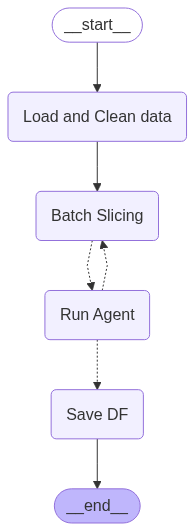

In [10]:
builder = StateGraph(MainState)

builder.add_node("Load and Clean data", process_data_cluster)
builder.add_node("Batch Slicing", split_data_process_for_batch)
builder.add_node("Run Agent", agent_attempt_2)
builder.add_node("Save DF", save_dataframe)

builder.add_edge(START, "Load and Clean data")
builder.add_edge("Load and Clean data", "Batch Slicing")
builder.add_conditional_edges("Batch Slicing", async_send_conditional, ["Run Agent"])

builder.add_conditional_edges("Run Agent", 
                              loop_batch_conditional, 
                              {
                                  "Save DF": "Save DF",
                                  "Batch Slicing": "Batch Slicing"
                              })
builder.add_edge("Save DF", END)

graph_execute = builder.compile()
display(Image(graph_execute.get_graph(xray=True).draw_mermaid_png()))

In [14]:
init_input = {
    "cluster": "C5",
    "cluster_url": "datasets_csv/dataset_C5_clean.csv",
    "current_offset": 0  # C
}

config = {"recursion_limit": 800}
messages = graph_execute.invoke(init_input, config)

processing 0 to 15 out of 803
processing 15 to 30 out of 803
processing 30 to 45 out of 803
processing 45 to 60 out of 803
processing 60 to 75 out of 803
processing 75 to 90 out of 803
processing 90 to 105 out of 803
processing 105 to 120 out of 803
processing 120 to 135 out of 803
processing 135 to 150 out of 803
processing 150 to 165 out of 803
processing 165 to 180 out of 803
processing 180 to 195 out of 803
processing 195 to 210 out of 803
processing 210 to 225 out of 803
processing 225 to 240 out of 803
processing 240 to 255 out of 803
processing 255 to 270 out of 803
processing 270 to 285 out of 803
processing 285 to 300 out of 803
processing 300 to 315 out of 803
processing 315 to 330 out of 803
processing 330 to 345 out of 803
processing 345 to 360 out of 803
processing 360 to 375 out of 803
processing 375 to 390 out of 803
processing 390 to 405 out of 803
processing 405 to 420 out of 803
processing 420 to 435 out of 803
processing 435 to 450 out of 803
processing 450 to 465 ou

In [12]:
df = pd.read_csv("results_C4_from_attempt2.csv")

In [13]:
df.to_excel("results_C4_from_attempt2.xlsx")